# RCT for ML Tools Synthetic Experiments

Code for synthetic simulations of randomized controlled trials for ML tools.



In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

Generate synthetic dataset.

In [67]:
def generate_data(n=5000):
    """
    Generate synthetic data for the experiments.
    Input:
    n: the size of the synthetic dataset

    Output:
    a pandas dataframe with the synthetic data
    """

    # generate a variable representing baseline patient covariates where
    # each category is assigned unformly at random
    X = np.random.choice([0,1,2,3], size=n, p=[1/4., 1/4., 1/4., 1/4.])

    # generate a variable to represent randomization to different cluster
    # 0 means control cluster, 1 means policy1, and 2 means policy2
    # assignment to clusters is uniformly at random
    D = np.random.choice([0,1,2], size=n, p=[1/3., 1/3., 1/3.])

    # define the behavior of policy 1
    def policy1(x):
        if x == 1:
            return 1
        else:
            return 0
    
    # define the behavior of policy 2
    def policy2(x):
        if x == 2 or x == 3:
            return 1
        else:
            return 0
        
    # define the behavior of policy e
    def policye(x):
        if x == 1 or x == 2 or x == 3:
            return 1
        else:
            return 0
        
    # define the behavior of policy e2
    def policye2(x):
        if x == 0 or x == 1:
            return 1
        else:
            return 0
    
    # generate the policy outputs for each patient covariate
    P0 = np.array([0 for x in X])
    P1 = np.array([policy1(x) for x in X])
    P2 = np.array([policy2(x) for x in X])
    Pe = np.array([policye(x) for x in X])
    Pe2 = np.array([policye2(x) for x in X])

    # generate whether the deployed model alerts, which is a deterministic function of D and the policy
    # that was deployed
    A = []
    for i in range(n):
        a = int(D[i] == 0)*0 + int(D[i] == 1)*P1[i] + int(D[i] == 2)*P2[i]
        A.append(a)

    # generate whether each patient experiences sepsis, which is defined as a Bernoulli trial
    # depending on the patient's covariates
    O = []
    for i in range(n):
        if X[i] == 0:
            p = 0.9
        elif X[i] == 1:
            p = 0.7
        elif X[i] == 2:
            p = 0.6
        elif X[i] == 3:
            p = 0.5
        O.append(np.random.binomial(1, p, 1)[0])
    O = np.array(O)

    # define model performance for each of the policies
    # model performance is deterministic based on the accuracy of the deployed model defined by D
    M = []
    for i in range(n):
        m = int(D[i] == 0)*round(np.mean(P0 == O), 2) + int(D[i] == 1)*round(np.mean(P1 == O), 2) + int(D[i] == 2)*round(np.mean(P2 == O), 2)

        M.append(m)

    # define the data generating process of Y, which is also a Bernoulli trial where the probability of success
    # is defined as a function of x, a, and m below
    def pY(x, a, m):
        if x == 0:
            p = 0.3
            if a == 1:
                p += 0.1
        elif x == 1:
            p = 0.4
            if a == 1:
                p += 0.5
        elif x == 2:
            p = 0.3
            if a == 1:
                p += 0.5
        elif x == 3:
            p = 0.2
            if a == 1:
                p += 0.5

        p += 0.1*m*a
        return p

    Y = []
    for i in range(n):
        Y.append(np.random.binomial(1, pY(X[i], A[i], M[i]), size=1)[0])

    # compute the true effect of deploying P0 and print it
    effect_p0 = 0
    for x in [0,1,2,3]:
        a = 0
        effect_p0 += pY(x, a, round(np.mean(0 == O), 2))
    print('true effect of p0', effect_p0/4)

    # compute the true effect of deploying P1 and print it
    effect_p1 = 0
    for x in [0,1,2,3]:
        a = policy1(x)
        effect_p1 += pY(x, a, round(np.mean(P1 == O), 2))
    print('true effect of p1', effect_p1/4)

    # compute the true effect of deploying P1 and print it
    effect_p2 = 0
    for x in [0,1,2,3]:
        a = policy2(x)
        effect_p2 += pY(x, a, round(np.mean(P2 == O), 2))
    print('true effect of p1', effect_p2/4)

    # compute the true effect of deploying Pe and print it
    effect_pe = 0
    for x in [0,1,2,3]:
        a = policye(x)
        effect_pe += pY(x, a, round(np.mean(Pe == O), 2))
    print('true effect of pe', effect_pe/4)

    # compute the true effect of deploying Pe2 and print it
    effect_pe2 = 0
    for x in [0,1,2,3]:
        a = policye2(x)
        effect_pe2 += pY(x, a, round(np.mean(Pe2 == O), 2))
    print('true effect of pe2', effect_pe2/4)

    # combine the data to make the final dataframe
    data = pd.DataFrame({'X': X, 'D': D, 'P0': P0, 'P1': P1, 'P2': P2, 'Pe': Pe, 'Pe2': Pe2, 'A': A, 'Y': Y, 'M': M, 'O': O})

    return (data, effect_p0/4, effect_p1/4, effect_p2/4, effect_pe/4, effect_pe2/4)

In [86]:
def estimate_counterfactual(data, Pe, M_Pe, A, X, D, M, Y, Ymin, Ymax, a_0):
    """
    Input:
    data - a pandas dataframe containing the data
    Pe - string containing the name of the policy we want to evaluate
    M_Pe - the performance of the model Pe
    A - string containing the name of the variable for A
    X - string containing the name of the variable for X
    D - string containing the name of the variable for D
    M - string containing the name of the variable for M
    Y - string containing the name of the variable for Y
    Ymin - the minimum value for Y
    Ymax - the maximum value for Y
    a_0 - the value of the neutral action

    Output:
    a tuple containing the lower and upper bounds for the performance of the model Pe,
    if the performance is point identified, then the lower and upper bounds will have
    the same value
    """
    # define sets with values of X where at least one trialed model matches in behavior and 
    # has different same, worse, or better performance
    x_equal = set()
    x_less = set()
    x_great = set()
    x_star = set()

    # get the unique values of X in the data
    X_values = np.unique(data[X])

    # get the unique values of D in the data
    D_values = np.unique(data[D])

    for x in X_values:
        # first subset to values in data where X=x
        data_subset_x = data[data[X] == x]

        for d in D_values:
            # next, subset to values where X=x and D=d
            data_subset_xd = data_subset_x[data_subset_x[D] == d]

            # see if pi_d has the same model behavior as pi_e and has the same performance under X=x
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1 and round(np.mean(data_subset_xd[M]), 2) == M_Pe:
                x_equal.add(x)
            
            # see if pi_d has the same model behavior as pi_e and has worse performance under X=x
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1 and round(np.mean(data_subset_xd[M]), 2) < M_Pe:
                x_less.add(x)

            # see if pi_d has the same model behavior as pi_e and has better performance under X=x
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1 and round(np.mean(data_subset_xd[M]), 2) > M_Pe:
                x_great.add(x)

            # see if pi_d has the same model behavior as pi_e
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1:
                x_star.add(x)

    # subtract out x_equal from x_less and x_great so that we are not double counting
    x_less = x_less - x_equal
    x_great = x_great - x_equal

    # get the values of x that do not fit into either of the above two sets
    x_lessequal = set(X_values) - x_equal - x_less
    x_greatequal = set(X_values) - x_equal - x_great
    print('x_star', x_star)

    # define functions of X that return a set in domain of D for each value of x
    # define them as dictionaries since the domain of these functions is just the domain of X (0,1,2,3);
    # the key of the dictionary is the input to the function, and the value is the output of the function (a set in the domain of D)
    S_equal = dict()
    S_less = dict()
    S_great = dict()
    S_star = dict()

    for x in X_values:
        # compute the output to the functions above for values of X=x
        data_subset_x = data[data[X] == x]

        cur_s_equal = set()
        cur_s_less = set()
        cur_s_great = set()
        cur_s_star = set()

        for d in D_values:
            data_subset_xd = data_subset_x[data_subset_x[D] == d]

            # see if pi_d has the same model behavior as pi_e and has the same performance under X=x
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1 and round(np.mean(data_subset_xd[M]), 2) == M_Pe:
                cur_s_equal.add(d)
            
            # see if pi_d has the same model behavior as pi_e and has worse performance under X=x
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1 and round(np.mean(data_subset_xd[M]), 2) < M_Pe:
                cur_s_less.add(d)

            # see if pi_d has the same model behavior as pi_e and has better performance under X=x
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1 and round(np.mean(data_subset_xd[M]), 2) > M_Pe:
                cur_s_great.add(d)

            # see if pi_d has the same model behavior as pi_e
            if np.mean(data_subset_xd[A] == data_subset_xd[Pe]) == 1:
                cur_s_star.add(d)

        S_equal[x] = cur_s_equal
        S_less[x] = cur_s_less
        S_great[x] = cur_s_great
        S_star[x] = cur_s_star

    print('S_star', S_star)
    # define a function that computes the probability that D is in a set d_set
    def p_D(d_set):
        return len(data[data[D].isin(d_set)]) / len(data)
    
    # define a special divide operation that prevents us from dividing by 0
    # we divide by 0 sometimes in the estimating functional but that doesn't hurt us because the indicator for that divide by 0
    # will be "turned off" anyways
    def special_divide(numerator, denominator):
        if denominator == 0:
            return 0
        else:
            return numerator/denominator
    
    # choose a critical value of 1.96 corresponding to 95% confidence intervals
    crit = 1.96

    # calculate the value of the target estimand for each row of data
    L_values = []
    for index, row in data.iterrows():
        L_values.append( row[Y] * ( int(row[X] in x_equal) * int(row[A] != a_0) * (special_divide(int(row[D] in S_equal[row[X]]), p_D(S_equal[row[X]]))) \
                            + int(row[X] in x_less) * int(row[A] != a_0) * (special_divide(int(row[D] in S_less[row[X]]), p_D(S_less[row[X]])))  ) \
                            + Ymin * int(row[X] in x_lessequal) * int(row[A] != 0) \
                            + row[Y] * int(row[X] in x_star) * int(row[A] == a_0) * (special_divide(int(row[D] in S_star[row[X]]), p_D(S_star[row[X]]))) \
                            + Ymin * int(row[X] not in x_star) * int(row[A] == a_0) )
    lower_mean = np.mean(L_values)
    # compute confidence intervals for the lower bound value
    lower_se = np.std(L_values)/np.sqrt(len(data))
    lower_lowbound = lower_mean - (crit * lower_se)
    lower_upbound = lower_mean + (crit * lower_se)

    U_values = []
    for index, row in data.iterrows():
        U_values.append( row[Y] * ( int(row[X] in x_equal) * int(row[A] != a_0) * (special_divide(int(row[D] in S_equal[row[X]]), p_D(S_equal[row[X]]))) \
                            + int(row[X] in x_great) * int(row[A] != a_0) * (special_divide(int(row[D] in S_great[row[X]]), p_D(S_great[row[X]])))  ) \
                            + Ymax * int(row[X] in x_greatequal) * int(row[A] != a_0) \
                            + row[Y] * int(row[X] in x_star) * int(row[A] == a_0) * (special_divide(int(row[D] in S_star[row[X]]), p_D(S_star[row[X]]))) 
                            #\
                            #+ Ymax * int(row[X] not in x_star) * int(row[A] == a_0) 
                            )
    upper_mean = np.mean(U_values)
    # compute confidence intervals for the upper bound value
    upper_se = np.std(U_values)/np.sqrt(len(data))
    upper_lowbound = upper_mean - (crit * upper_se)
    upper_upbound = upper_mean + (crit * upper_se)

    return (lower_mean, upper_mean, lower_lowbound, upper_upbound)

NameError: name 'S_star' is not defined

In [87]:
np.random.seed(0)

(data, effect_p0, effect_p1, effect_p2, effect_pe, effect_pe2) = generate_data(5000)

Pe_effect = estimate_counterfactual(data, 'Pe', round(np.mean(data['Pe'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
print(Pe_effect)

true effect of p0 0.3
true effect of p1 0.43575
true effect of p1 0.5680000000000001
true effect of pe 0.71025
true effect of pe2 0.482
x_star {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
S_star {np.int64(0): {np.int64(0), np.int64(1), np.int64(2)}, np.int64(1): {np.int64(1)}, np.int64(2): {np.int64(2)}, np.int64(3): {np.int64(2)}}
(np.float64(0.6777386494356535), np.float64(0.3196), np.float64(0.6446381879466753), np.float64(0.3325257754501925))


In [79]:
np.random.seed(0)

(data, effect_p0, effect_p1, effect_p2, effect_pe, effect_pe2) = generate_data(5000)

print('model accuracy')
print('P0', np.mean(data['P0'] == data['O']))
print('P1', np.mean(data['P1'] == data['O']))
print('P2', np.mean(data['P2'] == data['O']))
print('Pe', np.mean(data['Pe'] == data['O']))
print('Pe2', np.mean(data['Pe2'] == data['O']))

print('model effect on outcome')
P0_effect = estimate_counterfactual(data, 'P0', round(np.mean(data['P0'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
P1_effect = estimate_counterfactual(data, 'P1', round(np.mean(data['P1'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
P2_effect = estimate_counterfactual(data, 'P2', round(np.mean(data['P2'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
Pe_effect = estimate_counterfactual(data, 'Pe', round(np.mean(data['Pe'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)
Pe2_effect = estimate_counterfactual(data, 'Pe2', round(np.mean(data['Pe2'] == data['O']), 2), 'A', 'X', 'D', 'M', 'Y', 0, 1, 0)

print('P0', P0_effect[0], P0_effect[1])
print('P1', P1_effect[0], P1_effect[1])
print('P2', P2_effect[0], P2_effect[1])
print('Pe', Pe_effect[0], Pe_effect[1])
print('Pe2', Pe2_effect[0], Pe2_effect[1])

objects = [r'$\pi_0$', r'$\pi_1$', r'$\pi_2$', r'$\pi_{e0}$', r'$\pi_{e1}$']
performances = []
performances.append(np.mean(data['P0'] == data['O']))
performances.append(np.mean(data['P1'] == data['O']))
performances.append(np.mean(data['P2'] == data['O']))
performances.append(np.mean(data['Pe'] == data['O']))
performances.append(np.mean(data['Pe2'] == data['O']))

expected_outcomes = []
expected_outcomes.append(effect_p0)
expected_outcomes.append(effect_p1)
expected_outcomes.append(effect_p2)
expected_outcomes.append(effect_pe)
expected_outcomes.append(effect_pe2)

midpoints = [effect_p0, effect_p1, effect_p2, effect_pe, effect_pe2]
intervals = []
intervals.append((P0_effect[2], P0_effect[3]))
intervals.append((P1_effect[2], P1_effect[3]))
intervals.append((P2_effect[2], P2_effect[3]))
intervals.append((Pe_effect[2], Pe_effect[3]))
intervals.append((Pe2_effect[2], Pe2_effect[3]))

true effect of p0 0.3
true effect of p1 0.43575
true effect of p1 0.5680000000000001
true effect of pe 0.71025
true effect of pe2 0.482
model accuracy
P0 0.3244
P1 0.4346
P2 0.3646
Pe 0.4748
Pe2 0.6354
model effect on outcome
x_star {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
S_star {np.int64(0): {np.int64(0), np.int64(1), np.int64(2)}, np.int64(1): {np.int64(0), np.int64(2)}, np.int64(2): {np.int64(0), np.int64(1)}, np.int64(3): {np.int64(0), np.int64(1)}}
x_star {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
S_star {np.int64(0): {np.int64(0), np.int64(1), np.int64(2)}, np.int64(1): {np.int64(1)}, np.int64(2): {np.int64(0), np.int64(1)}, np.int64(3): {np.int64(0), np.int64(1)}}
x_star {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
S_star {np.int64(0): {np.int64(0), np.int64(1), np.int64(2)}, np.int64(1): {np.int64(0), np.int64(2)}, np.int64(2): {np.int64(2)}, np.int64(3): {np.int64(2)}}
x_star {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
S_star {np.int64(0

In [65]:
print(midpoints)
intervals

[np.float64(0.3), np.float64(0.43575), np.float64(0.5680000000000001), np.float64(0.71025), np.float64(0.482)]


[(np.float64(0.28802551041206936), np.float64(0.3196231994307871)),
 (np.float64(0.40172945623131845), np.float64(0.44990470402375)),
 (np.float64(0.5272458302957539), np.float64(0.5842460181633413)),
 (np.float64(0.6446381879466753), np.float64(0.3325257754501925)),
 (np.float64(0.32540587183795566), np.float64(0.6288721557684679))]

In [61]:
# bar plots
def create_bar_plots(objects, performances, expected_outcomes, intervals, midpoints):
    bar_width = 0.4
    # positions for first cluster
    x = [1, 1.4, 1.8, 2.3, 2.7]
    # Positions for second cluster
    x2 = [3.5, 3.9, 4.3, 4.8, 5.2]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))

    colors = ['#B8BBB7', '#6D6960', '#7F7F95', '#E09D00', '#CC77CE']

    # Plot first cluster
    for i in range(len(objects)):
        ax.bar(x[i], performances[i], color=colors[i], width=bar_width)
    # Plot second cluster
    for i in range(len(objects)):
        ax.bar(x2[i], expected_outcomes[i], color=colors[i], width=bar_width)

    # Set x-axis labels
    ax.set_xticks(np.concatenate([x, x2]))
    ax.set_xticklabels(objects * 2, fontsize=12)
    
    # Add labels for the two clusters
    mid_x1 = np.mean(x)  # Midpoint for first cluster
    mid_x2 = np.mean(x2)  # Midpoint for second cluster
    ax.text(mid_x1, -0.12, "Accuracy", ha='center', fontsize=12, fontweight='bold')
    ax.text(mid_x2, -0.12, "Expected Survival Rate", ha='center', fontsize=12, fontweight='bold')

    # Labels and title
    # ax.set_xlabel("Accuracy                                               Expected Survival Rate")
    ax.set_ylabel("Accuracy/Expected Survival Rate")
    ax.set_title("Accuracies and Expected Survival Rates Under Deployed\nand New Models")
    # ax.legend()

    error_bar_pos = [3.5, 3.9, 4.3, 4.8, 5.2]
    errors = []
    i = 0
    for interval in intervals:
        mid = midpoints[i]
        i += 1

        errors.append([[abs(mid - interval[0])],
                       [abs(mid - interval[1])]])
    print(errors)
    
    for i in range(len(error_bar_pos)):
        ax.errorbar(error_bar_pos[i], midpoints[i], yerr=errors[i], fmt=' ', color='b', ecolor='b', capsize=5, capthick=2, elinewidth=2)

    # Show the plot
    plt.show()

[[[np.float64(0.011974489587930626)], [np.float64(0.01962319943078711)]], [[np.float64(0.03402054376868158)], [np.float64(0.014154704023749964)]], [[np.float64(0.04075416970424617)], [np.float64(0.016246018163341258)]], [[np.float64(0.06561181205332478)], [np.float64(0.37772422454980753)]], [[np.float64(0.15659412816204432)], [np.float64(0.1468721557684679)]]]


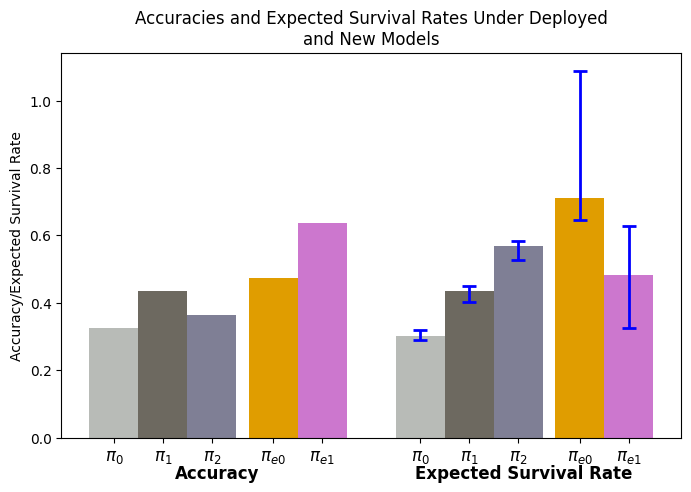

In [62]:
create_bar_plots(objects, performances, expected_outcomes, intervals, midpoints)